In [74]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable 

In [2]:
df = pd.read_csv('data_with_indicators.csv')

<AxesSubplot:>

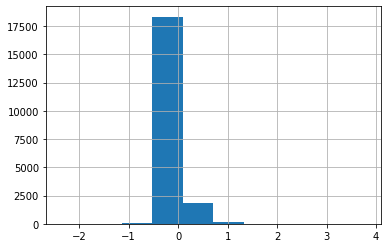

In [3]:
df["Y"].hist()

In [4]:
df = df[(df['Y']>-0.2)&(df['Y']<0.2)] 

<AxesSubplot:>

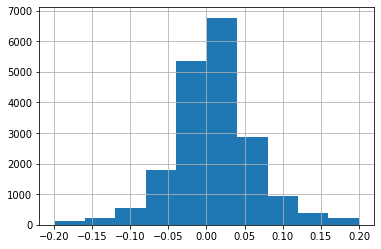

In [5]:
df["Y"].hist()

In [6]:
for e in df.isna().sum():
    if e != 0:
        print(e)

83
83
83
83
83
83
74


In [7]:
df = df.dropna()

In [8]:
dummy = pd.get_dummies(df['Ticker'])
df = pd.merge(df, dummy, left_index=True, right_index=True, how='inner')
df = df.drop('Ticker', axis=1)

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
min(df['Date'])

Timestamp('2004-02-11 00:00:00')

In [11]:
# df['year'] = df['Date'].dt.year
# df['month'] = df['Date'].dt.month

In [12]:
df['nb_months'] = ((df['Date'] - pd.to_datetime('2004-02'))/np.timedelta64(1, 'M'))

In [13]:
df['nb_months'] = df['nb_months'].astype(int)

In [14]:
df = df.drop('Date', axis=1)

In [15]:
correlation_matrix = df.corr()

In [16]:
correlation_matrix

,Category,Value,Timestamp,Open,High,Low,Close,Adj Close,Volume,Y,...,WPC,WRLD,WSM,WSO,WWW,WY,XOM,YUM,ZD,nb_months
Category,1.000000,0.041233,-0.003191,0.056245,0.056273,0.056271,0.056292,-0.010096,-0.049916,0.008423,...,-0.019760,-0.023973,0.057497,0.048103,-0.055887,-0.018560,-0.029820,-0.058254,0.040462,-0.003208
Value,0.041233,1.000000,-0.146068,0.053072,0.053033,0.053004,0.052939,0.009258,-0.008706,-0.003821,...,0.010742,-0.003688,0.013859,0.010696,0.033401,-0.000937,0.012516,-0.008281,-0.014487,-0.146139
Timestamp,-0.003191,-0.146068,1.000000,0.026120,0.026203,0.026129,0.026172,0.003945,-0.027703,-0.023416,...,-0.029033,-0.069483,-0.015445,0.027340,-0.041411,-0.020246,-0.050685,-0.006629,-0.034775,0.999989
Open,0.056245,0.053072,0.026120,1.000000,0.999963,0.999914,0.999849,0.000493,-0.006486,0.008680,...,-0.002270,-0.002968,-0.003326,-0.001997,-0.002678,-0.002095,-0.002093,-0.002666,-0.002332,0.026104
High,0.056273,0.053033,0.026203,0.999963,1.000000,0.999898,0.999892,0.000494,-0.006497,0.008771,...,-0.002276,-0.002971,-0.003330,-0.001996,-0.002685,-0.002099,-0.002090,-0.002674,-0.002334,0.026187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY,-0.018560,-0.000937,-0.020246,-0.002095,-0.002099,-0.002096,-0.002100,0.000292,-0.002039,-0.010249,...,-0.001676,-0.002033,-0.002622,-0.002715,-0.001700,1.000000,-0.001863,-0.002033,-0.001547,-0.020209
XOM,-0.029820,0.012516,-0.050685,-0.002093,-0.002090,-0.002096,-0.002095,0.000346,0.031293,-0.001899,...,-0.001983,-0.002406,-0.003103,-0.003214,-0.002012,-0.001863,1.000000,-0.002406,-0.001831,-0.050690
YUM,-0.058254,-0.008281,-0.006629,-0.002666,-0.002674,-0.002666,-0.002674,0.000377,-0.002090,-0.004294,...,-0.002164,-0.002626,-0.003386,-0.003507,-0.002196,-0.002033,-0.002406,1.000000,-0.001999,-0.006654
ZD,0.040462,-0.014487,-0.034775,-0.002332,-0.002334,-0.002335,-0.002336,0.000287,-0.004011,-0.000914,...,-0.001648,-0.001999,-0.002577,-0.002669,-0.001672,-0.001547,-0.001831,-0.001999,1.000000,-0.034823


In [17]:
y = df['Y']
X = df.drop("Y", axis=1)

## XGBoost

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

In [73]:
params_CV_xgb_only = {'colsample_bytree': 1, 
                      'eval_metric': 'rmse', 
                      'gamma': 3, 
                      'grow_policy': 'depthwise', 
                      'learning_rate': 0.03, 
                      'max_depth': 8, 
                      'n_estimators': 500, 
                      'reg_alpha': 0, 
                      'reg_lambda': 3, 
                      'subsample': 0.8}

In [74]:
eval_set = [(X_train, y_train), (X_val, y_val)]

model_xgb = XGBRegressor(**params_CV_xgb_only)
model_xgb.fit(X_train,
              y_train,
              verbose=0,
              eval_set=eval_set,
              eval_metric='rmse',
              early_stopping_rounds=50
              )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=16, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=3, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [77]:
y_pred = model_xgb.predict(X_test, ntree_limit=model_xgb.best_ntree_limit)

c:\users\kkwas\pycharmprojects\pythonproject\venv\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [78]:
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))

Testing performance
RMSE: 0.04
R2: 0.37
MAE: 0.03


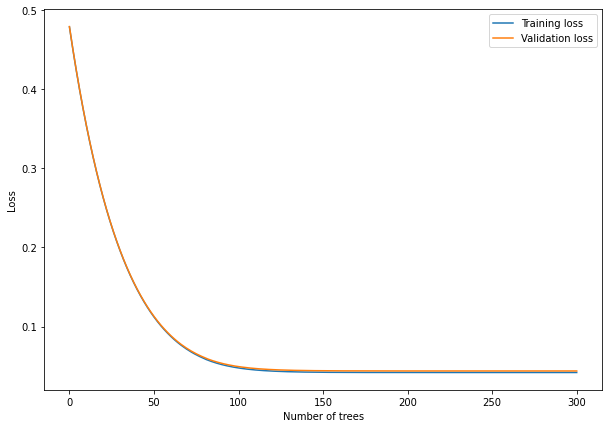

In [81]:
# plot error
results = model_xgb.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
# plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [84]:
params_CV_xgb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.03],
    'max_depth': [4, 6],
    'eval_metric': ['rmse'],
    'colsample_bytree': [1],
    'subsample': [0.8],
    'reg_alpha': [0, 1],
    'grow_policy': ['depthwise'],
    'reg_lambda': [0, 3],
    'gamma':[0, 3]
}


In [90]:
model = XGBRegressor()
kf=KFold(n_splits=2)
model_cv = GridSearchCV(estimator = model, 
                        param_grid = params_CV_xgb, 
                        scoring= 'neg_root_mean_squared_error', 
                        cv = kf, 
                        verbose = 100,
                        return_train_score=True)  

In [89]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [91]:
x = model_cv.fit(X_train, y_train)
model = x.best_estimator_
print(x.best_params_)
pred = model.predict(X_test)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[CV 1/2; 1/64] START colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_rate=0.05, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.8
[CV 1/2; 1/64] END colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_rate=0.05, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=(train=-0.025, test=-0.029) total time=   1.4s
[CV 2/2; 1/64] START colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_rate=0.05, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.8
[CV 2/2; 1/64] END colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_rate=0.05, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=(train=-0.025, test=-0.028) total time=   1.4s
[CV 1/2; 2/64] START colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_

In [92]:
y_pred = model_cv.predict(X_test)

In [98]:
y_pred_train = model_cv.predict(X_train)

In [93]:
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))

Testing performance
RMSE: 0.02
R2: 0.82
MAE: 0.01


In [94]:
# {'colsample_bytree': 1, 'eval_metric': 'rmse', 'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}

In [71]:
import seaborn as sns
def plot_scatter_avp(actuals, predictions):
        df = pd.DataFrame({"actual": actuals, "predicted": predictions})

        max_actual = max(df.actual)

        fig = sns.scatterplot(data=df, x="actual", y="predicted", s=3, marker="o")
        fig.plot(np.linspace(0, max_actual), np.linspace(0, max_actual), "-r")
        plt.show()

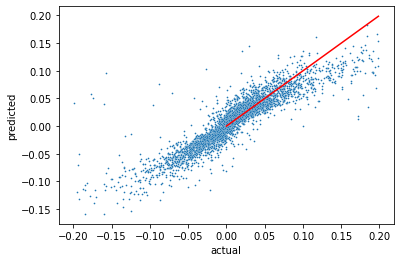

In [97]:
plot_scatter_avp(y_test, y_pred)

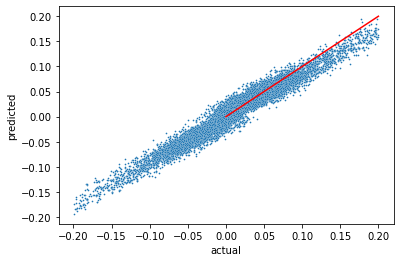

In [99]:
plot_scatter_avp(y_train, y_pred_train)

## LSTM/GRU 

In [18]:
X_dl = X.to_numpy()
y_dl = y.to_numpy()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_dl, y_dl, test_size=0.2, random_state=420)

In [20]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [21]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], X_train_tensors.shape[1], 1))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], X_test_tensors.shape[1], 1)) 

In [22]:
X_train_tensors_final.shape

torch.Size([15272, 495, 1])

In [23]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

In [24]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                          num_layers=num_layers, 
                            batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [27]:
model = LSTM(input_dim=input_dim, 
             hidden_dim=hidden_dim, 
             output_dim=output_dim, 
             num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(X_train_tensors_final)
    loss = criterion(y_train_pred, y_train_tensors)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

c:\users\kkwas\pycharmprojects\pythonproject\venv\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([15272])) that is different to the input size (torch.Size([15272, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 MSE:  0.014247039332985878
Epoch  1 MSE:  0.012886828742921352
Epoch  2 MSE:  0.005582157522439957
Epoch  3 MSE:  0.0029675750993192196
Epoch  4 MSE:  0.004534550942480564
Epoch  5 MSE:  0.005457490682601929
Epoch  6 MSE:  0.004901775624603033
Epoch  7 MSE:  0.0037883203476667404
Epoch  8 MSE:  0.003028755309060216
Epoch  9 MSE:  0.003014299087226391
Epoch  10 MSE:  0.003498805919662118
Epoch  11 MSE:  0.0038640303537249565
Epoch  12 MSE:  0.0037785267923027277
Epoch  13 MSE:  0.0033958163112401962
Epoch  14 MSE:  0.003044934943318367
Epoch  15 MSE:  0.0029198762495070696
Epoch  16 MSE:  0.0030070391949266195
Epoch  17 MSE:  0.0031747345346957445
Epoch  18 MSE:  0.0032915682531893253
Epoch  19 MSE:  0.0032915547490119934
Epoch  20 MSE:  0.0031870263628661633
Epoch  21 MSE:  0.0030480094719678164
Epoch  22 MSE:  0.002946653636172414
Epoch  23 MSE:  0.002914441516622901
Epoch  24 MSE:  0.0029470534063875675
Epoch  25 MSE:  0.003009016625583172
Epoch  26 MSE:  0.00305421743541955

In [35]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(X_test_tensors_final)
y_test_pred.shape

torch.Size([3819, 1])

In [36]:
# invert predictions
# y_train_pred = y_train_pred.detach().numpy()
y_train = y_train_tensors.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
y_test = y_test_tensors.detach().numpy()

In [41]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


In [44]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_dl, y_dl, test_size=0.2, random_state=420)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], X_train_tensors.shape[1], 1))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], X_test_tensors.shape[1], 1)) 

In [51]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(X_train_tensors_final)
    loss = criterion(y_train_pred, y_train_tensors)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

KeyboardInterrupt: 

In [47]:
y_test_pred = model(X_test_tensors_final)
y_test_pred.shape

torch.Size([3819, 1])

In [49]:
y_train_pred = y_train_pred.detach().numpy()
y_train = y_train_tensors.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
y_test = y_test_tensors.detach().numpy()

In [50]:
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


## Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
params_CV_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 4],
    'bootstrap': [True],
    'max_samples': [0.75, 1]
    
}

In [65]:
rf = RandomForestRegressor()

In [66]:
kf=KFold(n_splits=3)
model_cv = GridSearchCV(estimator = rf, 
                        param_grid = params_CV_rf, 
                        scoring= 'neg_mean_squared_error', 
                        cv = kf, 
                        verbose = 100,
                        return_train_score=True)  

In [67]:
x = model_cv.fit(X_train, y_train)
model = x.best_estimator_
print(x.best_params_)
pred = model.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100
[CV 1/3; 1/36] END bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100;, score=(train=-0.001, test=-0.001) total time=  16.7s
[CV 2/3; 1/36] START bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100
[CV 2/3; 1/36] END bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100;, score=(train=-0.001, test=-0.001) total time=  16.7s
[CV 3/3; 1/36] START bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100
[CV 3/3; 1/36] END bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100;, score=(train=-0.001, test=-0.001) total time=  16.6s
[CV 1/3; 2/36] START bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=300
[CV 1/3; 2/36] END bootstrap=True, ma

In [68]:
y_pred_train = model_cv.predict(X_train)

In [70]:
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))

Testing performance
RMSE: 0.03
R2: 0.72
MAE: 0.02


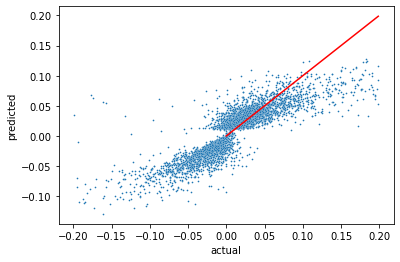

In [75]:
plot_scatter_avp(y_test, pred)

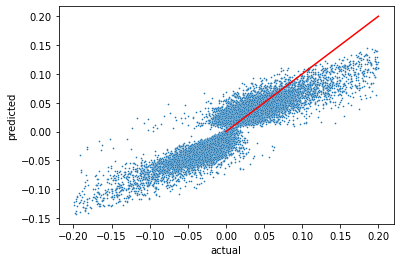

In [76]:
plot_scatter_avp(y_train, y_pred_train)

In [ ]:
# {'bootstrap': True, 'max_depth': 8, 'max_samples': 0.75, 'min_samples_split': 2, 'n_estimators': 500}